In [1]:
# Basic
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

# IO
import netCDF4 as nc

# PyTorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.distributions import Uniform
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, PolynomialLR

# PyTorch-Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split

# Wandb
import wandb

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

In [3]:
pl.seed_everything(125)

Global seed set to 125


125

In [4]:
data = nc.Dataset("data/kepler.nc").variables
keys = data.keys()
vals = data.values()

data_dict = {}

for k, v in zip(keys, vals):
    data_dict[k] = np.array(v[:])

df = pd.DataFrame(data_dict)

In [5]:
df

,t,x,y,vx,vy,E,L,g
0,0.000000,2.919807,-2.386163,-0.582427,0.015088,-0.095470,-1.345712,0
1,0.009153,2.914474,-2.386024,-0.582926,0.015496,-0.095470,-1.345712,0
2,0.018306,2.909136,-2.385880,-0.583426,0.015906,-0.095470,-1.345712,0
3,0.027459,2.903793,-2.385732,-0.583926,0.016316,-0.095470,-1.345712,0
4,0.036612,2.898447,-2.385581,-0.584427,0.016728,-0.095470,-1.345712,0
...,...,...,...,...,...,...,...,...
50003,90.252157,3.218096,-3.962491,0.411937,0.171525,-0.096343,2.184281,4
50004,90.261185,3.221815,-3.960941,0.411718,0.171794,-0.096343,2.184281,4
50005,90.270214,3.225531,-3.959389,0.411500,0.172063,-0.096343,2.184281,4
50006,90.279243,3.229245,-3.957834,0.411281,0.172331,-0.096343,2.184281,4


In [6]:
groups = np.unique(df.g)
groups

array([0, 1, 2, 3, 4], dtype=uint64)

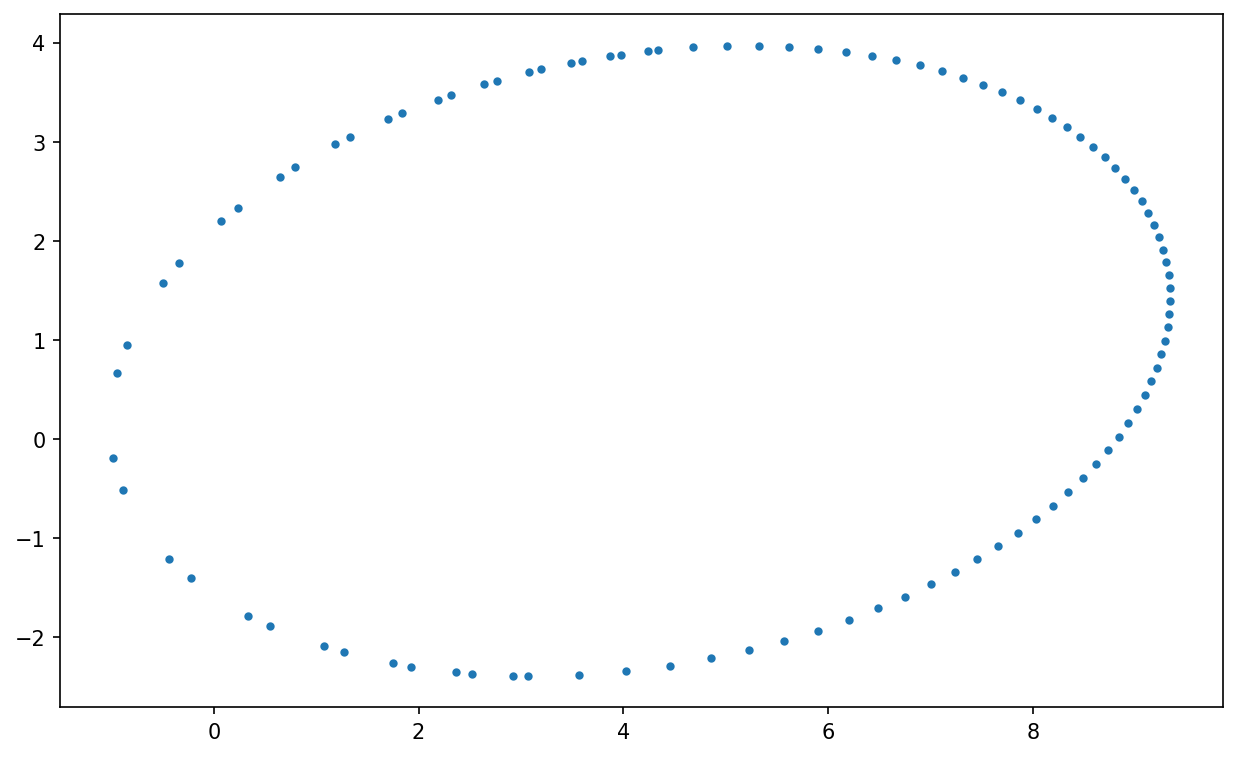

In [7]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(df.x[df.g==0][::100], df.y[df.g==0][::100], '.')
plt.show()

In [8]:
class Kepler2D(Dataset):
    def __init__(self, df):
        X = df.to_numpy()
        self.X = torch.tensor(X[:, 1:-3], dtype=torch.float32)
        self.g = torch.tensor(X[:, -1:], dtype=torch.uint8).reshape((-1,1))
        self.L = torch.tensor(X[:, -2:-1], dtype=torch.float32).reshape((-1,1))
        self.E = torch.tensor(X[:, -3:-2], dtype=torch.float32).reshape((-1,1))
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.g[idx], self.L[idx], self.E[idx]

In [9]:
ds = Kepler2D(df)

In [10]:
len(ds)

50008

In [11]:
ds[0]

(tensor([ 2.9198, -2.3862, -0.5824,  0.0151]),
 tensor([0], dtype=torch.uint8),
 tensor([-1.3457]),
 tensor([-0.0955]))

In [12]:
class ASNet(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        
        self.h1_n  = hparams["hidden_layer_1_nodes"]
        self.h1_d  = hparams["hidden_layer_1_depth"]
        self.h2_n  = hparams["hidden_layer_2_nodes"]
        self.h2_d  = hparams["hidden_layer_2_depth"]
        self.lr    = hparams["learning_rate"]
        self.batch = hparams["batch_size"]
        self.epoch = hparams["epoch"]
#         self.gamma = hparams["gamma"]
        
        E_vec = torch.tensor(hparams["E_init"], dtype=torch.float32)
        L_vec = torch.tensor(hparams["L_init"], dtype=torch.float32)
        
        self.E = nn.Parameter(E_vec, requires_grad=True)
        self.L = nn.Parameter(L_vec, requires_grad=True)
        self.group = len(self.E)
        
        assert(self.group == len(self.L))
        
        h1 = [
            nn.Linear(4, self.h1_n),
            nn.GELU(),
            nn.BatchNorm1d(self.h1_n)
        ]
        
        for i in range(self.h1_d):
            h1.extend([
                nn.Linear(self.h1_n, self.h1_n),
                nn.GELU(),
                nn.BatchNorm1d(self.h1_n)
            ])
            
        h1.append(nn.Linear(self.h1_n, 2)) # E, L
        
        h2 = [
            nn.Linear(3, self.h2_n),
            nn.GELU(),
            nn.BatchNorm1d(self.h2_n)
        ]
        
        for i in range(self.h2_d):
            h2.extend([
                nn.Linear(self.h2_n, self.h2_n),
                nn.GELU(),
                nn.BatchNorm1d(self.h2_n)
            ])
        
        h2.append(nn.Linear(self.h2_n, 2))
        
        self.net1 = nn.Sequential(*h1)
        self.net2 = nn.Sequential(*h2)
        
        self.save_hyperparameters(hparams)
        
        self.ds = None
        
    def _forward_features(self, x):
        x = self.net1(x)
        return x
    
    def forward(self, x):
        X, _, _, _ = x
        th = torch.atan(X[:,1:2] / X[:,0:1])
        x = self._forward_features(x)
        x = torch.column_stack([x, th])
        return self.net2(x)
    
    def training_step(self, batch, batch_idx):
        # Decompose Batch
        X, g, _, _ = batch
        x  = X[:,0:1]
        y  = X[:,1:2]
        vx = X[:,2:3]
        vy = X[:,3:4]
        th = torch.atan(y/x)
        
        # Decompose First Output
        EL   = self._forward_features(X)
        E    = EL[:,0:1]
        L    = EL[:,1:2]
        ELTh = torch.column_stack([E, L, th])
        
        # Obtain group indices
        g_ics_vec = [g == i for i in range(self.group)]
        
        E_aux = torch.ones_like(E)
        L_aux = torch.ones_like(L)
        
        for (g_ics, E_a, L_a) in zip(g_ics_vec, self.E, self.L):
            E_aux[g_ics[:,0]] *= E_a
            L_aux[g_ics[:,0]] *= L_a
        
        # Reconstruct position
        RV     = self.net2(ELTh)
        R      = RV[:,0:1]
        V      = RV[:,1:2]
        x_hat  = R * torch.cos(th)
        y_hat  = R * torch.sin(th)
        vx_hat = -V * torch.sin(th)
        vy_hat = V * torch.cos(th)
        
        loss_x  = ((x - x_hat)**2).mean()
        loss_y  = ((y - y_hat)**2).mean()
        loss_vx = ((vx-vx_hat)**2).mean()
        loss_vy = ((vy-vy_hat)**2).mean()
        loss_E = ((E - E_aux)**2).mean()
        loss_L = ((L - L_aux)**2).mean()
        
        loss = loss_x + loss_y + loss_E + loss_L + loss_vx + loss_vy
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Decompose Batch
        X, g, _, _ = batch
        x  = X[:,0:1]
        y  = X[:,1:2]
        vx = X[:,2:3]
        vy = X[:,3:4]
        th = torch.atan(y/x)
        
        # Decompose First Output
        EL   = self._forward_features(X)
        E    = EL[:,0:1]
        L    = EL[:,1:2]
        ELTh = torch.column_stack([E, L, th])
        
        # Obtain group indices
        g_ics_vec = [g == i for i in range(self.group)]
        
        E_aux = torch.ones_like(E)
        L_aux = torch.ones_like(L)
        
        for (g_ics, E_a, L_a) in zip(g_ics_vec, self.E, self.L):
            E_aux[g_ics[:,0]] *= E_a
            L_aux[g_ics[:,0]] *= L_a
        
        # Reconstruct position
        RV     = self.net2(ELTh)
        R      = RV[:,0:1]
        V      = RV[:,1:2]
        x_hat  = R * torch.cos(th)
        y_hat  = R * torch.sin(th)
        vx_hat = -V * torch.sin(th)
        vy_hat = V * torch.cos(th)
        
        loss_x  = ((x - x_hat)**2).mean()
        loss_y  = ((y - y_hat)**2).mean()
        loss_vx = ((vx-vx_hat)**2).mean()
        loss_vy = ((vy-vy_hat)**2).mean()
        loss_E = ((E - E_aux)**2).mean()
        loss_L = ((L - L_aux)**2).mean()
        
        loss = loss_x + loss_y + loss_E + loss_L + loss_vx + loss_vy
        
        self.log('val_loss', loss)
        self.log('loss_x', loss_x)
        self.log('loss_y', loss_y)
        self.log('loss_E', loss_E)
        self.log('loss_L', loss_L)
        
        for i, (g_ics, E_a, L_a) in enumerate(zip(g_ics_vec, self.E, self.L)):
            E_mean = E[g_ics[:,0]].mean()
            L_mean = L[g_ics[:,0]].mean()

            self.log(f"E_{i}", E_mean)
            self.log(f"L_{i}", L_mean)
            self.log(f"E_a_{i}", E_a)
            self.log(f"L_a_{i}", L_a)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": PolynomialLR(
                optimizer,
                total_iters=self.epoch,
                power=2.0
            )
        }
    
    def prepare_data(self):
        self.ds = ds
        self.N = len(self.ds)
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch)

In [13]:
pl.seed_everything(8407)

Global seed set to 8407


8407

In [14]:
with open('best_model_path.txt', 'r') as f:
    best_model_path = f.read()

In [15]:
best_model_path

'./Auxiliary_Symmetry/2k9nj51f/checkpoints/epoch=300-step=41237.ckpt'

In [16]:
model = ASNet.load_from_checkpoint(best_model_path)

## Analysis

In [17]:
model.eval()
dl_total = DataLoader(ds, batch_size=BATCH_SIZE)

In [18]:
def decoder(model, dl):
    dl_iter = iter(dl)
    X_init, g, _, _ = next(dl_iter)
    g_ics_vec = [g == i for i in range(model.group)]
    th = torch.atan(X_init[:,1:2] / X_init[:,0:1])
    
    EL   = model._forward_features(X_init)
    E    = EL[:,0:1]
    L    = EL[:,1:2]
    ELTh = torch.column_stack([E, L, th])
    
    RV = model.net2(ELTh)
    R = RV[:,0:1]
    V = RV[:,1:2]
    x_hat = R * torch.cos(th)
    y_hat = R * torch.sin(th)
    vx_hat = -V * torch.sin(th)
    vy_hat = V * torch.cos(th)
    
    output_vec = [
        torch.column_stack([
            x_hat[g_ics[:,0]],
            y_hat[g_ics[:,0]],
            vx_hat[g_ics[:,0]],
            vy_hat[g_ics[:,0]],
            E[g_ics[:,0]],
            L[g_ics[:,0]]
        ]) for g_ics in g_ics_vec
    ]
    
    for data in dl_iter:
        X, g, _, _ = data
        g_ics_vec = [g == i for i in range(model.group)]
        th = torch.atan(X[:,1:2] / X[:,0:1])
    
        EL   = model._forward_features(X)
        E    = EL[:,0:1]
        L    = EL[:,1:2]
        ELTh = torch.column_stack([E, L, th])

        RV = model.net2(ELTh)
        R = RV[:,0:1]
        V = RV[:,1:2]
        x_hat = R * torch.cos(th)
        y_hat = R * torch.sin(th)
        vx_hat = -V * torch.sin(th)
        vy_hat = V * torch.cos(th)
        
        output_vec = [
            torch.concat([
                a,
                torch.column_stack([
                    x_hat[g_ics[:,0]],
                    y_hat[g_ics[:,0]],
                    vx_hat[g_ics[:,0]],
                    vy_hat[g_ics[:,0]],
                    E[g_ics[:,0]],
                    L[g_ics[:,0]]
                ])
            ]) for (a, g_ics) in zip(output_vec, g_ics_vec)
        ]
    return output_vec

In [19]:
output_vec = decoder(model, dl_total)

In [20]:
[print(output.shape) for output in output_vec];

torch.Size([10002, 6])
torch.Size([10002, 6])
torch.Size([10002, 6])
torch.Size([10001, 6])
torch.Size([10001, 6])


In [21]:
X0 = output_vec[0].detach().numpy()

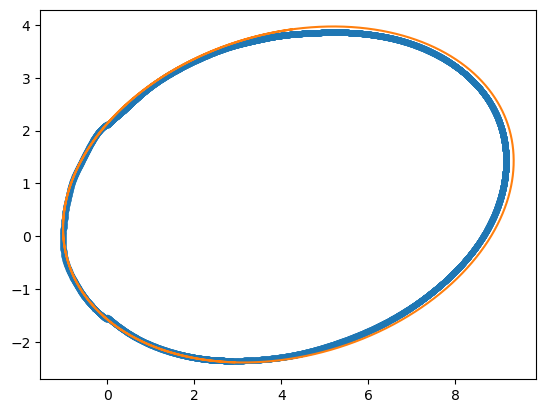

In [22]:
x_hat = X0[:,0]
y_hat = X0[:,1]

plt.plot(x_hat, y_hat, '.')
plt.plot(df.x[df.g==0], df.y[df.g==0])
plt.show()

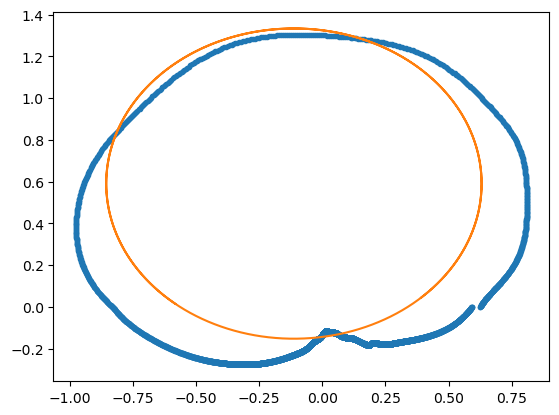

In [23]:
vx_hat = X0[:,2]
vy_hat = X0[:,3]

plt.plot(vx_hat, vy_hat, '.')
plt.plot(df.vx[df.g==0], df.vy[df.g==0])
plt.show()

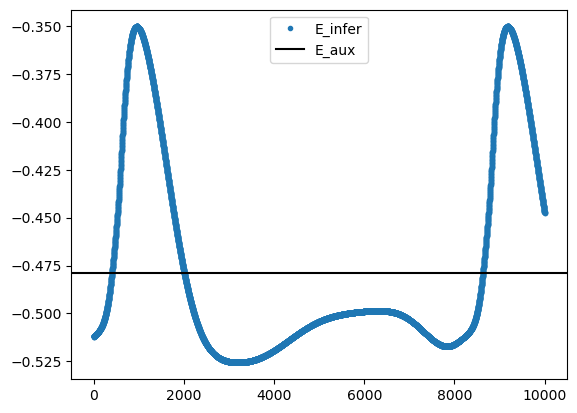

In [24]:
plt.plot(X0[:,4], '.', label='E_infer')
plt.axhline(model.E[0].detach().numpy(), color='k', label='E_aux')
# plt.plot(df.E[df.g==0])
plt.legend()
plt.show()

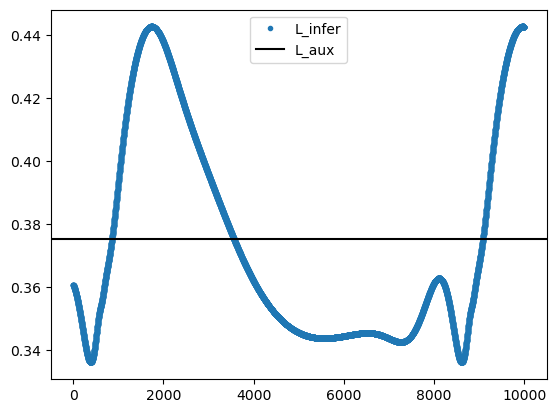

In [25]:
plt.plot(X0[:,5], '.', label='L_infer')
plt.axhline(model.L[0].detach().cpu(), color='k', label='L_aux')
plt.legend()
plt.show()

## Symbolic Regression

In [26]:
from pysr import PySRRegressor

In [27]:
ds = Kepler2D(df[::10])

In [28]:
dl_total = DataLoader(ds, batch_size=BATCH_SIZE)

In [29]:
output_vec = decoder(model, dl_total)

In [30]:
[print(output.shape) for output in output_vec];

torch.Size([1001, 6])
torch.Size([1000, 6])
torch.Size([1000, 6])
torch.Size([1000, 6])
torch.Size([1000, 6])


In [31]:
output_np = [output.detach().numpy() for output in output_vec]

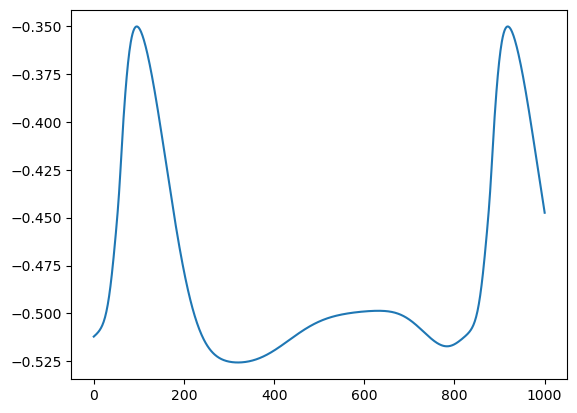

In [32]:
plt.plot(output_np[0][:,4])
plt.show()

In [33]:
E_vec = [model.E[i].detach().numpy() for i in range(5)]
L_vec = [model.L[i].detach().numpy() for i in range(5)]

In [34]:
X_out = np.row_stack(output_np)

In [35]:
X_out.shape

(5001, 6)

In [36]:
X_in = X_out[:,0:4]
E_target = X_out[:,4:5]
L_target = X_out[:, 5:6]

In [37]:
model_sr = PySRRegressor(
    niterations=10,
    population_size=100,
    maxdepth=10,
    binary_operators=["+", "-", "*"],
    unary_operators=["sqrt"],
)

In [38]:
model_sr.fit(X_in, L_target)

/home/kavis/.local/lib/python3.10/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/kavis/.local/lib/python3.10/site-packages/pysr/julia_helpers.py:151: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before* importing `torch`. For updates, see https://github.com/pytorch/pytorch/issues/78829
  warnings.warn(


Started!

Cycles per second: 1.320e+05
Head worker occupation: 7.2%
Progress: 120 / 150 total iterations (80.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.118e-03  -1.000e-10  0.36325273
5           6.214e-04  3.066e-01  ((x1 * 0.010464846) + 0.35542858)
6           6.093e-04  1.954e-02  sqrt((x1 * 0.0075098034) + 0.12781335)
8           6.085e-04  6.863e-04  sqrt(((x1 + x3) * 0.0075098034) + 0.12781335)
9           4.265e-04  3.554e-01  (((x1 - (x0 * -0.23560616)) * 0.010464874) + 0.36003435)
11          2.758e-04  2.179e-01  (((x1 + ((x3 - -0.25877973) * x0)) * 0.010853361) + 0.35601997)
13          2.697e-04  1.134e-02  (((x1 + ((x3 - -0.24646533) * (x0 + x3))) * 0.010925413) + 0.35542858)
15          2.672e-04  4.495e-03  ((((x1 + ((x3 - -0.24646533) * x0)) + (x2 * x2)) * 0.010925413) + 0.35542858)
16          2.582e-04  3.448e-02  ((((x1 + ((x3 - -0.25059715) * x0)) + sqrt(x2 * x2)) * 0.010908398) + 0.35387853

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.36325273   
	1         0.306566                  ((x1 * 0.010464846) + 0.35542858)   
	2         0.019601              sqrt((x1 * 0.007536677) + 0.12781335)   
	3         0.000654      sqrt(((x1 + x3) * 0.0075098034) + 0.12781335)   
	4         0.355406  (((x1 - (x0 * -0.23560616)) * 0.010464874) + 0...   
	5   >>>>  0.217887  (((x1 + ((x3 - -0.25877973) * x0)) * 0.0108533...   
	6         0.011339  (((x1 + ((x3 - -0.24646533) * (x0 + x3))) * 0....   
	7         0.004824  ((((x1 + ((x3 - -0.2587749) * x0)) + (x2 * x2)...   
	8         0.033821  ((((x1 + ((x3 - -0.25059715) * x0)) + sqrt(x2 ...   
	9         0.009186  ((((x1 + ((x3 - -0.25059715) * x0)) + sqrt((x2...   
	10        0.006839  ((((x1 + ((x3 - -0.24902484) * (x0 + (x3 - 0.5...   
	
	        loss  complexity  
	0   0.002118           1  
	1   0.000621           5  
	2   0.000609           6  
	3   0.000608           8  
	4   0.000426           9  
	5   0.000276          11  
	6   0.000270          13  
	7   0.000267          15  
	8   0.000258          16  
	9   0.000253          18  
	10  0.000250          20  
]

In [39]:
model_sr.get_hof()

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.002118,0.000000,0.36325273,0.363252730000000,PySRFunction(X=>0.363252730000000)
1,5,0.000621,0.306566,((x1 * 0.010464846) + 0.35542858),0.010464846*x1 + 0.35542858,PySRFunction(X=>0.010464846*x1 + 0.35542858)
2,6,0.000609,0.019601,sqrt((x1 * 0.007536677) + 0.12781335),0.357509929932023*sqrt(0.0589662738673229*x1 + 1),PySRFunction(X=>0.357509929932023*sqrt(0.05896...
3,8,0.000608,0.000654,sqrt(((x1 + x3) * 0.0075098034) + 0.12781335),0.357509929932023*sqrt(0.0587560172704964*x1 +...,PySRFunction(X=>0.357509929932023*sqrt(0.05875...
4,9,0.000426,0.355406,(((x1 - (x0 * -0.23560616)) * 0.010464874) + 0...,0.00246558877802384*x0 + 0.010464874*x1 + 0.36...,PySRFunction(X=>0.00246558877802384*x0 + 0.010...
5,11,0.000276,0.217887,(((x1 + ((x3 - -0.25877973) * x0)) * 0.0108533...,0.010853361*x0*(x3 + 0.25877973) + 0.010853361...,PySRFunction(X=>0.010853361*x0*(x3 + 0.2587797...
6,13,0.000270,0.011339,(((x1 + ((x3 - -0.24646533) * (x0 + x3))) * 0....,0.010925413*x1 + 0.010925413*(x0 + x3)*(x3 + 0...,PySRFunction(X=>0.010925413*x1 + 0.010925413*(...
7,15,0.000267,0.004824,((((x1 + ((x3 - -0.2587749) * x0)) + (x2 * x2)...,0.010853119*x0*(x3 + 0.2587749) + 0.010853119*...,PySRFunction(X=>0.010853119*x0*(x3 + 0.2587749...
8,16,0.000258,0.033821,((((x1 + ((x3 - -0.25059715) * x0)) + sqrt(x2 ...,0.010908398*x0*(x3 + 0.25059715) + 0.010908398...,PySRFunction(X=>0.010908398*x0*(x3 + 0.2505971...
9,18,0.000253,0.009186,((((x1 + ((x3 - -0.25059715) * x0)) + sqrt((x2...,0.010908398*x0*(x3 + 0.25059715) + 0.010908398...,PySRFunction(X=>0.010908398*x0*(x3 + 0.2505971...


In [40]:
best_model_sr = model_sr.get_best()
best_model_sr

complexity                                                      11
loss                                                      0.000276
score                                                     0.217887
equation         (((x1 + ((x3 - -0.25877973) * x0)) * 0.0108533...
sympy_format     0.010853361*x0*(x3 + 0.25877973) + 0.010853361...
lambda_format    PySRFunction(X=>0.010853361*x0*(x3 + 0.2587797...
Name: 5, dtype: object

In [41]:
best_model_sr.sympy_format

0.010853361*x0*(x3 + 0.25877973) + 0.010853361*x1 + 0.35601997

In [42]:
L_infer = best_model_sr.lambda_format(X_in[:1000])

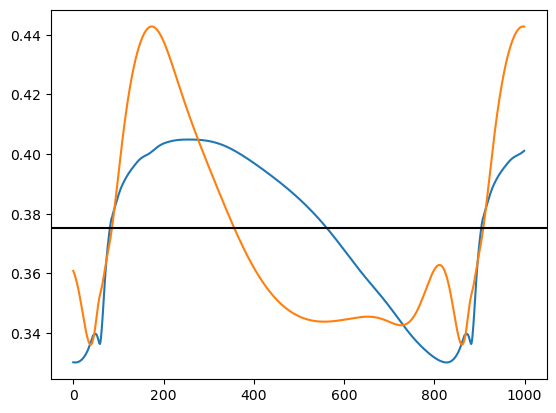

In [43]:
plt.plot(L_infer)
plt.plot(L_target[:1000])
plt.axhline(L_vec[0], color='k')
plt.show()

In [44]:
dg = df[::10]
dg

,t,x,y,vx,vy,E,L,g
0,0.000000,2.919807,-2.386163,-0.582427,0.015088,-0.095470,-1.345712,0
10,0.091530,2.866268,-2.384594,-0.587450,0.019230,-0.095470,-1.345712,0
20,0.183060,2.812266,-2.382639,-0.592551,0.023512,-0.095470,-1.345712,0
30,0.274590,2.757794,-2.380285,-0.597731,0.027942,-0.095470,-1.345712,0
40,0.366120,2.702843,-2.377519,-0.602994,0.032527,-0.095470,-1.345712,0
...,...,...,...,...,...,...,...,...
49960,89.863917,3.056356,-4.026804,0.421228,0.159693,-0.096343,2.184281,4
49970,89.954205,3.094291,-4.012259,0.419086,0.162493,-0.096343,2.184281,4
49980,90.044494,3.132032,-3.997463,0.416932,0.165263,-0.096343,2.184281,4
49990,90.134782,3.169579,-3.982418,0.414767,0.168005,-0.096343,2.184281,4


In [45]:
indices = [list(dg.g == i) for i in range(5)]

In [46]:
L_infer_vec = [best_model_sr.lambda_format(X_in[idx]) for idx in indices]

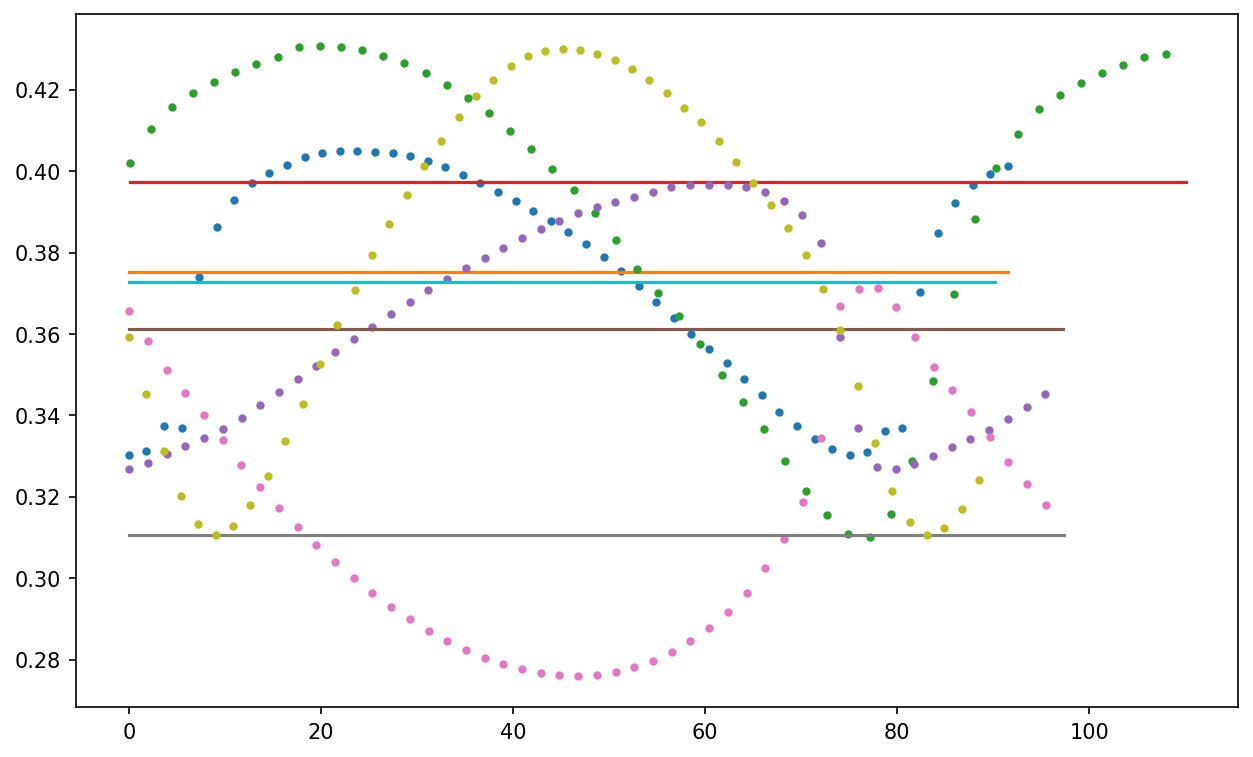

In [47]:
plt.figure(figsize=(10,6), dpi=150)
for i in range(5):
    plt.plot(dg.t[dg.g == i][::20], L_infer_vec[i][::20], '.')
    plt.plot(dg.t[dg.g == i], np.repeat(L_vec[i], len(dg.t[dg.g==i])))
plt.show()